# Look at bathymetry made using nemo_python

Github: https://github.com/knaughten/nemo_python/

In [2]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean
import pickle

#### Functions

In [3]:
def prepare_plot(figsize=(15, 15), dpi=300):
    """This function returns prepared axes for the polar plot.
    
    Usage:
        fig, ax = prepare_plot()
    """
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    ax.set_boundary(map_circle, transform=ax.transAxes)
    # ax.coastlines(); 
    gl = ax.gridlines(draw_labels=True, ylocs=[]);#, color='w', lw=2);
    return fig, ax

In [4]:
# compare side-by-side:
def plot_comparison(coord, dataset1, dataset2, title1='', title2='', vdiff=2, variable='bathy'):    
    
    fig, ax = plt.subplots(1,3, figsize=(20,7), subplot_kw={'projection': ccrs.SouthPolarStereo()}, dpi=300)
    
    for axis in ax.ravel():
        axis.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        axis.set_boundary(map_circle, transform=axis.transAxes)
        gl = axis.gridlines(draw_labels=True, ylocs=[]);
        # add 2000 m isobath contour to each of the plots 
        axis.plot(x_iso1, y_iso1, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
        axis.plot(x_iso2, y_iso2, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
    
    ax[0].set_title(f'{title1}')
    ax[1].set_title(f'{title2}')
    ax[2].set_title(f'{title2} minus {title1}')
    fig.suptitle(f'Variable: {variable}')
    
    # Separated bathymetries:
    kwags={'transform':ccrs.PlateCarree(), 'vmin':-6000, 'vmax':0, 'cmap':cmocean.cm.deep_r, 'rasterized':True}
    cm1 = ax[0].pcolormesh(coord.nav_lon, coord.nav_lat, dataset1[f'{variable}'], **kwags);
    cm2 = ax[1].pcolormesh(coord.nav_lon, coord.nav_lat, dataset2[f'{variable}'], **kwags);
    
    # Difference between the bathymetries:
    dataset1_plot = xr.where(np.isnan(dataset1[f'{variable}']), 0, dataset1[f'{variable}'])
    dataset2_plot = xr.where(np.isnan(dataset2[f'{variable}']), 0, dataset2[f'{variable}'])
    cm3 = ax[2].pcolormesh(coord.nav_lon, coord.nav_lat, (dataset2_plot - dataset1_plot), 
                           cmap=cmocean.cm.balance, transform=ccrs.PlateCarree(), vmin=-vdiff, vmax=vdiff, rasterized=True);
    
    CB = fig.colorbar(cm3, ax=ax[2], fraction=0.04)
    fig.set_facecolor('white')
    
    return fig

In [5]:
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

### Visualize bathymetry output

In [6]:
TERRA='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/'

bed        = xr.open_dataset('/gws/nopw/j04/terrafirma/kaight/input_data/topo/BedMachineAntarctica-v3.nc')
coord      = xr.open_dataset('/home/users/birgal/data/bathymetry/coordinates_AIS.nc').squeeze()
BedMachine = xr.open_dataset('/home/users/birgal/data/bathymetry/eORCA025_BedMachine3_AIS.nc')
IBCSO      = xr.open_dataset('/home/users/birgal/data/bathymetry/topo/IBCSO_v2_bed_WGS84.nc')
Bed_IBCSO  = xr.open_dataset(f'{TERRA}bathymetry/eORCA025_BedMachine3_IBCSO_AIS.nc')

In [7]:
# Load polygon from disc
with open('/home/users/birgal/data/IBCSO_isobath_2000m_polygon', "rb") as poly_file:
    isobath_2000m_polygon = pickle.load(poly_file)

x_iso, y_iso = isobath_2000m_polygon.exterior.xy
x_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(x_iso)) # need to separate longitudes because otherwise matplotlib plotting artifact
y_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(y_iso))
x_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(x_iso))
y_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(y_iso))

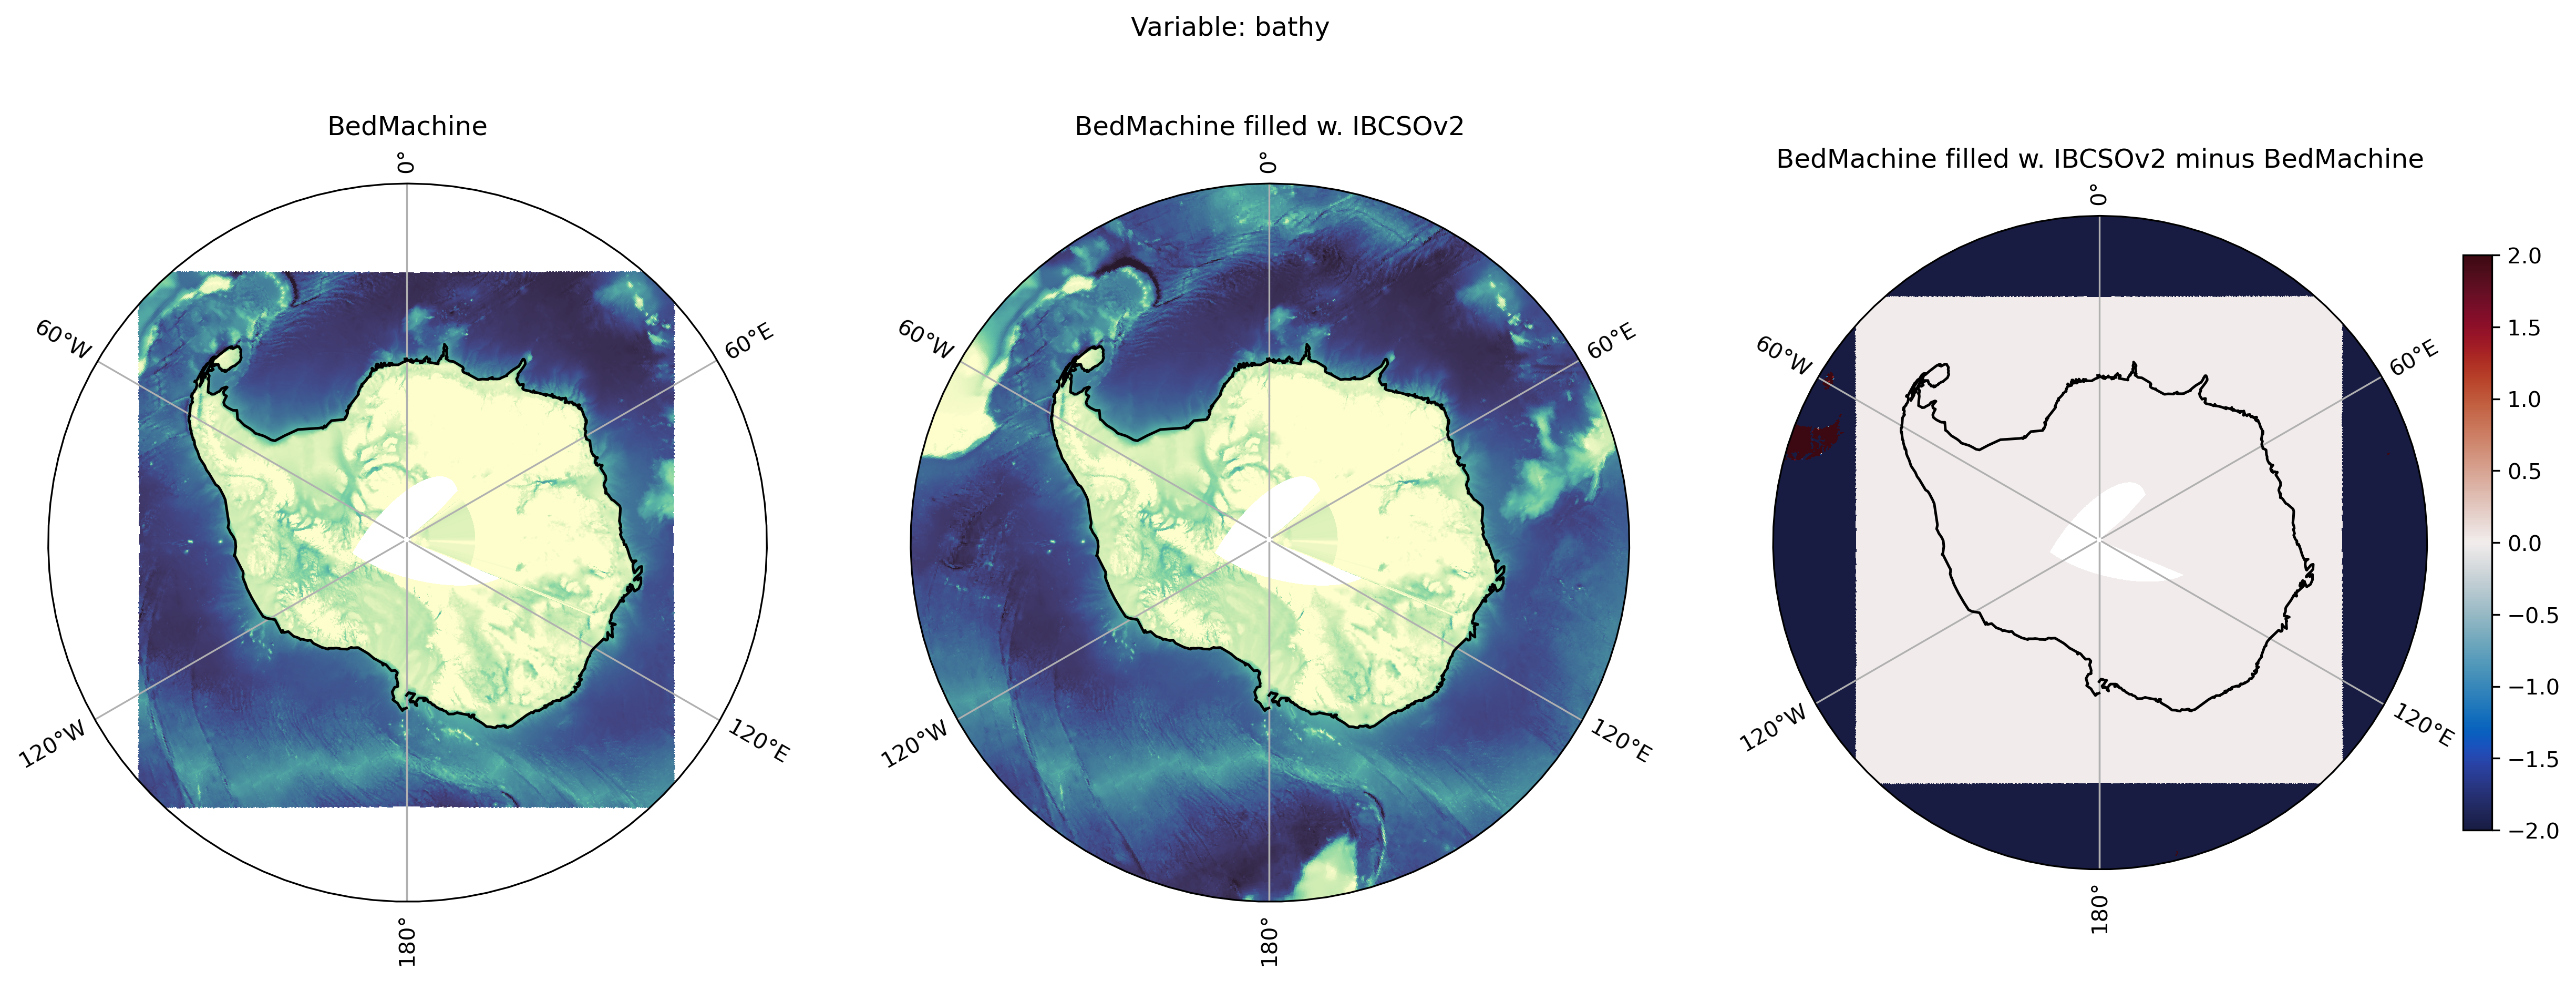

In [25]:
fig1 = plot_comparison(coord, BedMachine, Bed_IBCSO, variable='bathy',
                       title1='BedMachine', title2='BedMachine filled w. IBCSOv2', vdiff=2)

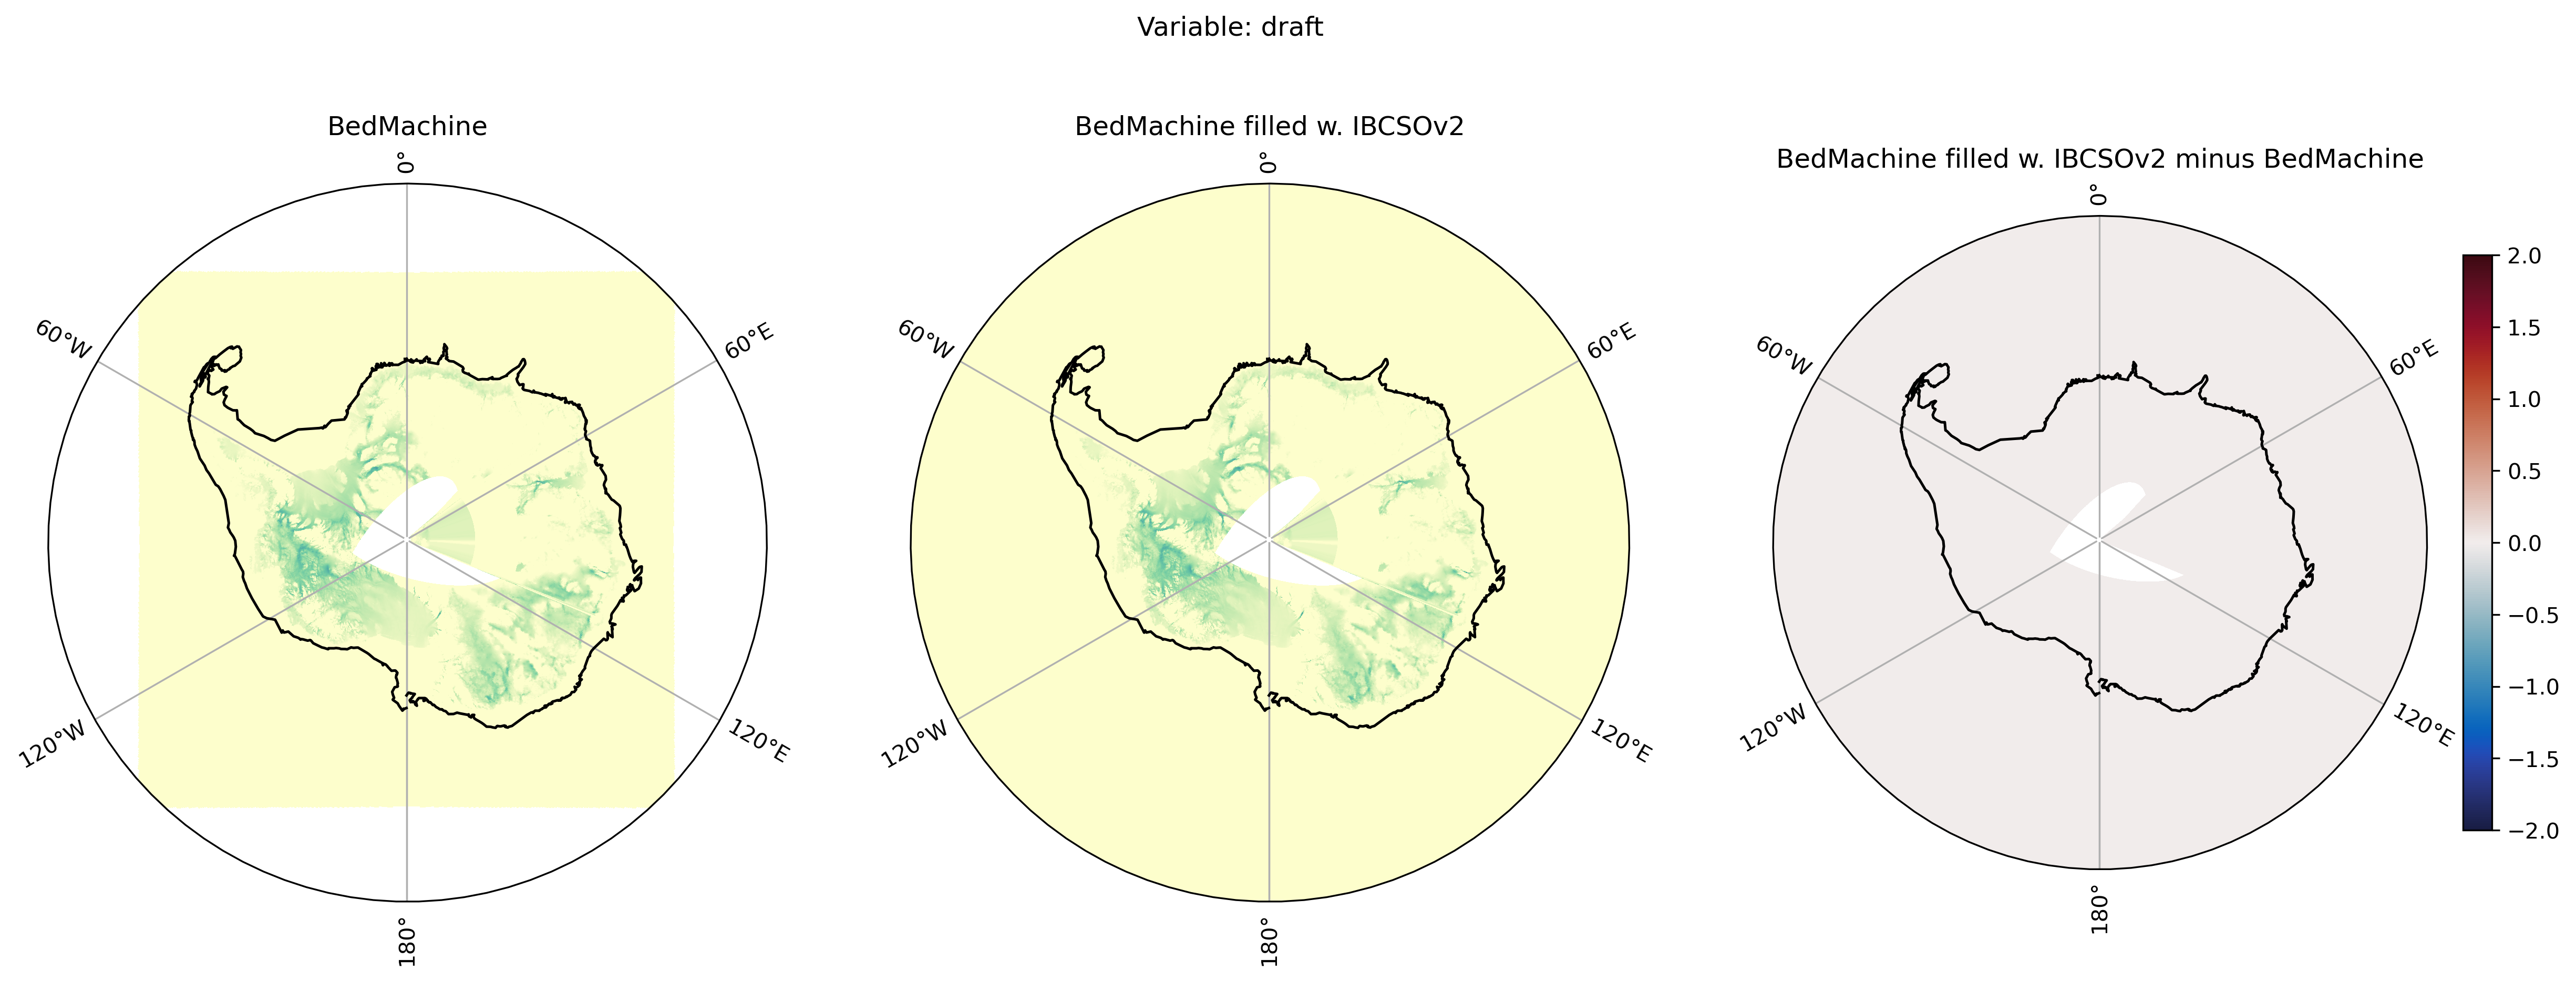

In [24]:
fig1 = plot_comparison(coord, BedMachine, Bed_IBCSO, variable='draft',
                       title1='BedMachine', title2='BedMachine filled w. IBCSOv2', vdiff=2)

In [74]:
# Draw a line where the BedMachine bathymetry edge is
BedMachine_masked = np.ma.masked_where(np.isnan(BedMachine['bathy']), coord.nav_lon)
edges = np.ma.notmasked_edges(BedMachine_masked, axis=0)

subset_navlon = coord.nav_lon.isel(x=xr.DataArray(edges[1][1], dims='z'), 
                                   y=xr.DataArray(edges[1][0], dims='z'))
subset_navlat = coord.nav_lat.isel(x=xr.DataArray(edges[1][1], dims='z'), 
                                   y=xr.DataArray(edges[1][0], dims='z'))

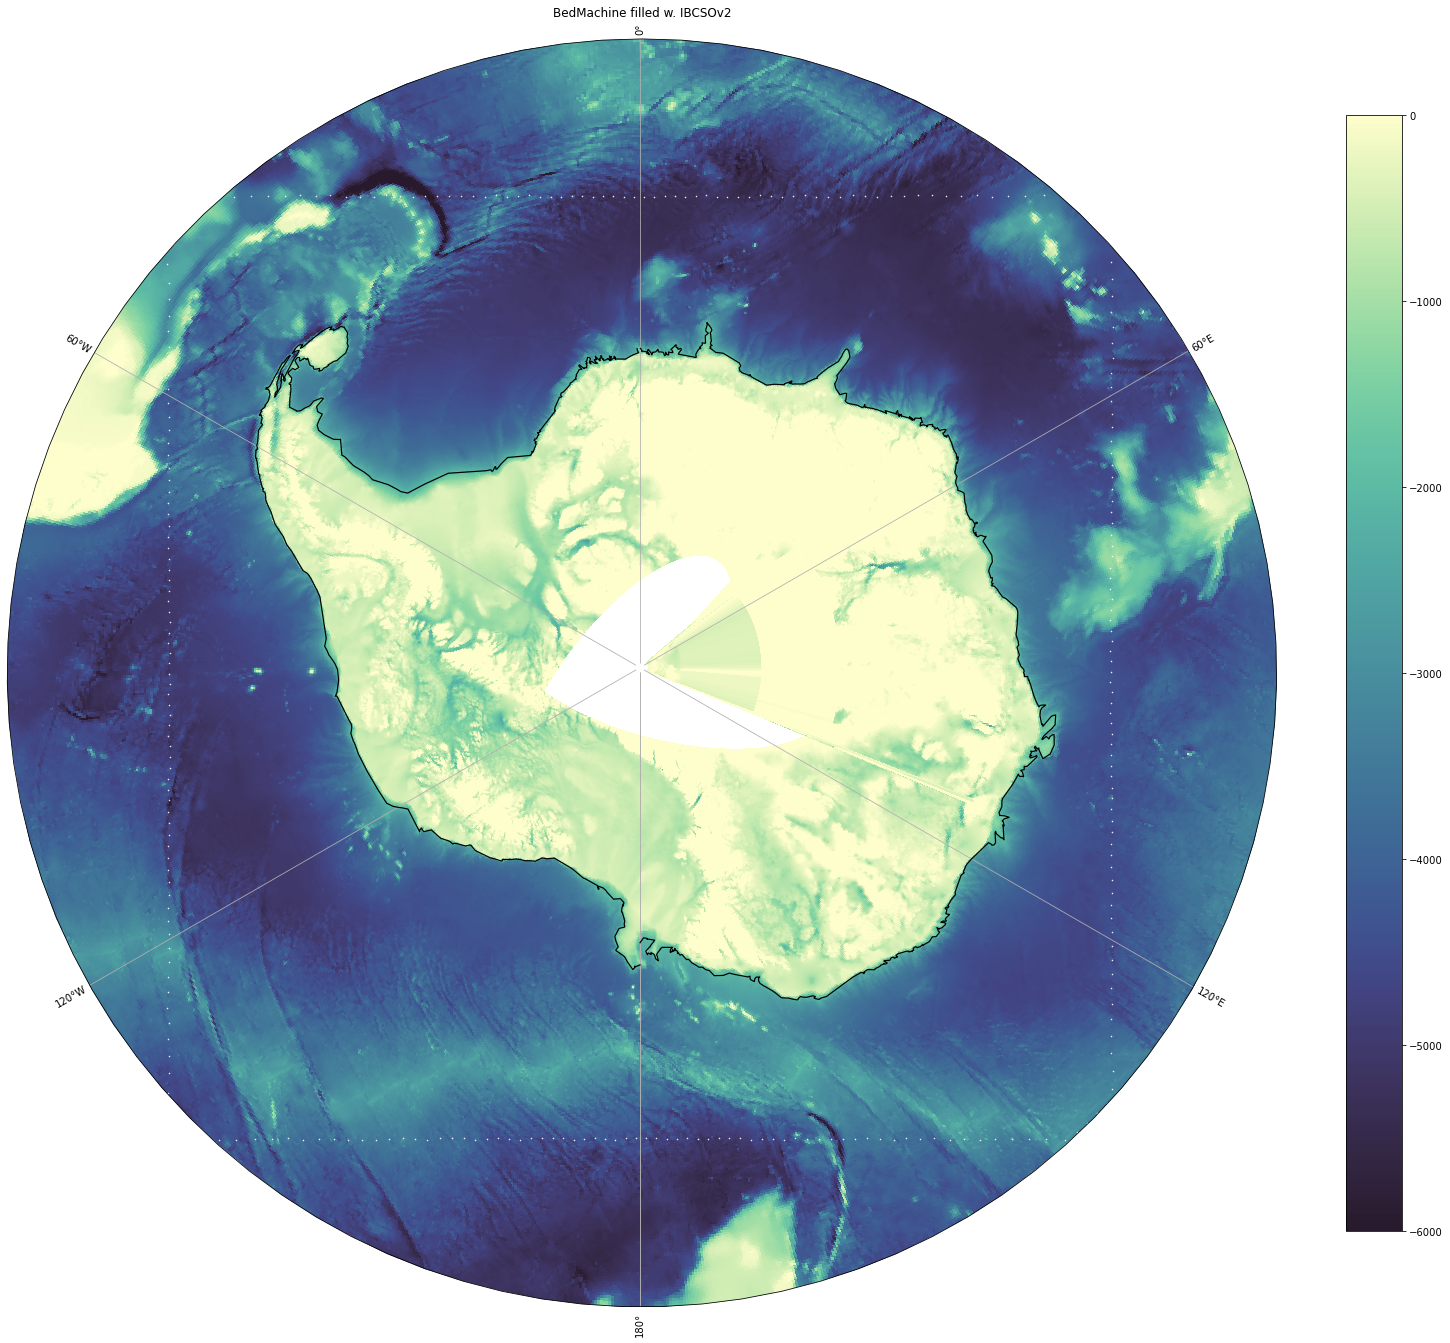

In [99]:
fig, ax = plt.subplots(1,1, figsize=(25,25), subplot_kw={'projection': ccrs.SouthPolarStereo()})

ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.set_boundary(map_circle, transform=ax.transAxes)
gl = ax.gridlines(draw_labels=True, ylocs=[]);
# add 2000 m isobath contour to each of the plots 
ax.plot(x_iso1, y_iso1, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='k', zorder=4, linewidth=1.2, transform=ccrs.PlateCarree())

ax.set_title('BedMachine filled w. IBCSOv2')

# Separated bathymetries:
kwags={'transform':ccrs.PlateCarree(), 'vmin':-6000, 'vmax':0, 'cmap':cmocean.cm.deep_r, 'rasterized':True}
cm1 = ax.pcolormesh(coord['nav_lon'], coord['nav_lat'], Bed_IBCSO['bathy'], **kwags);

# draw an edge to label where the edge of Bedmachine is located
ax.scatter(subset_navlon[::5], subset_navlat[::5], color='w', s=0.3, transform=ccrs.PlateCarree(), zorder=2)

CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
fig.set_facecolor('white')

# fig.savefig('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/BedMachine_IBCSOv2_bathymetry.pdf')

#### Digression: ceate isobath polygon

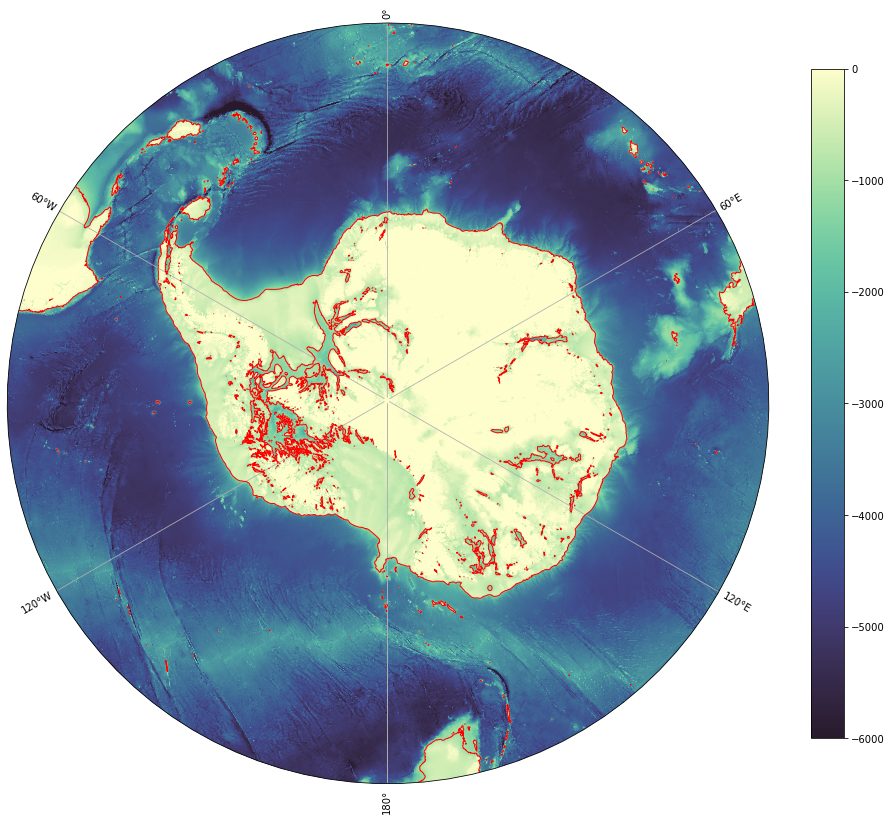

In [6]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(IBCSO['lon'][::10], 
                    IBCSO['lat'][::5],
                    IBCSO['z'][::5,::10], 
                    transform=ccrs.PlateCarree(), vmin=-6000, vmax=0, cmap=cmocean.cm.deep_r);

x, y = np.meshgrid(IBCSO['lon'], IBCSO['lat'])
cs  = ax.contour(x, y, IBCSO['z'], levels=[-1000], colors='r', linestyles='-', linewidths=1, zorder=4, transform=ccrs.PlateCarree())

CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
# CB.add_lines(cont1)

##### Make polygon of 2000 m isobath to separate domain:

In [7]:
# # Create largest polygon based on 2000 m contour line (excluding holes)
# for ncp, cp in enumerate(cs.collections[0].get_paths()[0].to_polygons()):
#     isobath_2000m = geometry.Polygon([(i[0], i[1]) for i in zip(cp[:,0],cp[:,1])])

# Create largest polygon based on 1000 m contour line (excluding holes)
for ncp, cp in enumerate(cs.collections[0].get_paths()[0].to_polygons()):
    isobath_1000m = geometry.Polygon([(i[0], i[1]) for i in zip(cp[:,0],cp[:,1])])

In [8]:
x_iso, y_iso = isobath_1000m.exterior.xy
x_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(x_iso))
y_iso1 = np.ma.masked_where(np.array(x_iso) < 0, np.array(y_iso))
x_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(x_iso))
y_iso2 = np.ma.masked_where(np.array(x_iso) >= 0, np.array(y_iso))

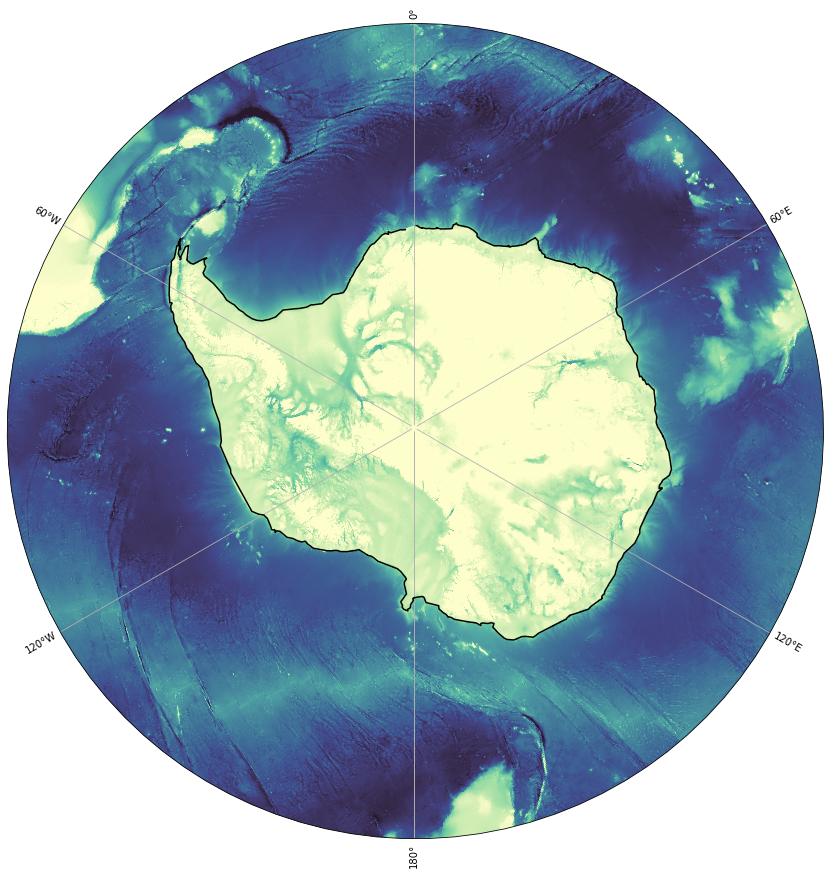

In [9]:
fig, ax = prepare_plot()
cm1 = ax.pcolormesh(IBCSO['lon'][::10], 
                    IBCSO['lat'][::5],
                    IBCSO['z'][::5,::10], 
                    transform=ccrs.PlateCarree(), vmin=-6000, vmax=0, cmap=cmocean.cm.deep_r);

ax.plot(x_iso1, y_iso1, c='k', zorder=4, transform=ccrs.PlateCarree())
ax.plot(x_iso2, y_iso2, c='k', zorder=4, transform=ccrs.PlateCarree())

# CB = fig.colorbar(cm1, ax=ax, fraction=0.04)
# CB.add_lines(cont1)

In [10]:
# Save polygon to disc
with open('/home/users/birgal/data/IBCSO_isobath_1000m_polygon', "wb") as poly_file:
    pickle.dump(isobath_1000m, poly_file, pickle.HIGHEST_PROTOCOL)